In [1]:
import numpy
from numpy import linalg as la

import sympy
from sympy import init_printing
init_printing()

import matplotlib.pyplot as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
## We use some functions from https://github.com/tabakg/potapov_interpolation

import sys
P_dir = '/Users/gil/Google Drive/repos/potapov/potapov_interpolation/Potapov_Code/'
sys.path.append(P_dir)
import Roots
from Potapov import get_Potapov_vecs
from functions import der
from functions import limit

## Symbols we will use for the construction.

In [3]:
r, kappa, eps, z = sympy.symbols('r kappa epsilon z')

## Functions we will use

In [4]:
def double_up(P, M, second_row_minus = False):
    """
    Generate a 'doubled-up' version of the positive (P) and negative (M) matrices.
    """
    r1 = M.col_join(P)
    r2 = (P.conjugate()).col_join(M.conjugate())
    if second_row_minus:
        r2 *= -1
    return r1.row_join(r2)

In [5]:
def J(n):
    """
    Generate the signature matrix of half-dimension n.
    
    I.e. J = [[I_n, 0],
              [0, -I_n]]
    """
    r1 = sympy.eye(n).col_join(sympy.zeros(n))
    r2 = sympy.zeros(n).col_join(-sympy.eye(n))
    return r1.row_join(r2)

In [6]:
def flat(M):
    """
    return J M^\dag J for the appropriate dimension of J.
    """
    m,n = M.shape
    if m%2 != 0 or n%2 != 0:
        raise ValueError("dimensions of matrix should be even.")
    return J(n/2)*M.H*J(m/2)

In [7]:
def make_ABCD(S, Phi, Omega):
    """
    Generate the ABCD matrices from the S, Phi, and Omega
    """
    D = double_up(sympy.zeros(S.shape[0]),S)
    B = -flat(Phi)*D
    A = -0.5*flat(Phi)*Phi - 1j*Omega
    C = Phi
    return A, B, C, D


def make_T(A, B, C, D):
    """
    Make the transfer function using the ABCD matrices.
    """
    IA = sympy.eye(A.shape[0])
    T_z = D + C*(z*IA - A).inv()*B
    return T_z

### Factorization-specific functions

In [8]:
def scale_vector_doubled_up(v):
    """Given a vector v, attempt to scale it so that 
    it has doubled-up form, u = Sigma*u^\#.
    
    Raises: ValueError
    """
    sub_sigma = numpy.diag([1]*(v.shape[0]/2))
    M = v.shape[0]/2
    Sigma = numpy.vstack((
                numpy.hstack((np.zeros((M,M)),sub_sigma)),
                numpy.hstack((sub_sigma,np.zeros((M,M))))
            ))
    angles = np.angle((Sigma*v).conj() / v)
    pos_angles = [a if a > 0 else a+2*numpy.pi for a in angles]
    u = v*numpy.exp(0.5j*pos_angles[0])
    if la.norm(u - Sigma*u.conj()) > 1e-5:
        raise ValueError("Vector cannot be scaled to doubled-up form.")
    return u

def real_scaling(v1, v2):
    """
    Scale the two vectors v1 and v2 appropriately, granted they 
    correspond to two real poles.
    """
    M = v1.shape[0]/2
    Jv = numpy.matrix(numpy.diag([1 for i in range(M)]+[-1 for i in range(M)]))
    N = v1.H*Jv*v2
    u1 = v1 / la.norm(numpy.sqrt(2*N))
    u2 = v2 / la.norm(numpy.sqrt(2*N))
    return u1, u2

In [9]:
def make_Sigma(M):
    """
    Generate the permutation matrix Sigma of half-dimension M.
    
    I.e. Sigma = [[0, I_M],
                  [I_M, 0]]
    """
    sub_sigma = numpy.diag([1]*M)
    Sigma = numpy.vstack((
                numpy.hstack((np.zeros((M,M)),sub_sigma)),
                numpy.hstack((sub_sigma,np.zeros((M,M))))
            ))
    return Sigma

In [10]:
def check_J_unitary(T, z, eps = 1e-5):
    """
    Check if the transfer function T is J-unitary at z.
    """
    T_mat1 = numpy.matrix(T(z))
    T_mat2 = numpy.matrix(T(-numpy.conj(z)))
    d = T_mat1.shape[0]/2
    Jv = numpy.matrix(numpy.diag([1 for i in range(d)]+[-1 for i in range(d)]))
    return la.norm(T_mat1*Jv*T_mat2.H - Jv) < eps

In [11]:
def check_doubled_up_func(T, z, eps = 1e-5):
    """
    Check if the transfer function T is doubled-up at z.
    """
    T_mat = numpy.matrix(T(z))
    dim = T_mat.shape[0]/2
    Sigma = make_Sigma(dim)
    

    return la.norm(Sigma * T(numpy.conj(z)).H * Sigma - T(z)) < eps

In [12]:
def check_doubled_up_mat(M, eps = 1e-5):
    """
    Check if the transfer function T is doubled-up at z.
    """
    d1, d2 = M.shape[0]/2, M.shape[1]/2
    Sigma1 = make_Sigma(d1)
    Sigma2 = make_Sigma(d2)

    return la.norm( (Sigma1 * M * Sigma2).conj() - M) < eps

In [13]:
def purge(lst, eps=1e-5):
    """
    Gets rid of redundant elements up to error eps.
    """
    if len(lst) <= 1:
        return lst

    new_lst = []
    for lst_i in lst:
        if all([abs(el - lst_i) > eps 
                for el in new_lst]):
            new_lst.append(lst_i)
    return new_lst

In [161]:
def complex_prod_deg(z, poles, vecs, dim, eps=1e-3):
    """
    Generate a complex product given complex poles and vectors,
    and evaluate at $z$.
    
    In the example, the complex eigenvectors were all degenerate,
    so we perturb the first component by $\eps$. In this case we
    actually need two terms to approximate the degenerate space.
    """
    M = dim/2
    R = numpy.matrix(numpy.eye(dim))
    J1 = numpy.matrix(numpy.diag([1, -1]))
    Jv = numpy.matrix(numpy.diag([1 for i in range(M)]+[-1 for i in range(M)]))
    sub_sigma = numpy.diag([1]*M)
    Sigma = numpy.vstack((
                numpy.hstack((np.zeros((M,M)),sub_sigma)),
                numpy.hstack((sub_sigma,np.zeros((M,M))))
            ))
    for p, eig in zip(poles, vecs):
        v1, val = eig
        
        v1[0,0] += eps

        v1 = v1 / numpy.sqrt(v1.H*J1*v1)
        if v1.H*J1*v1 > 0:
            V1 = numpy.hstack([v1, Sigma*v1.conj()])
        else: ## flipping v and \Sigma *v^# changes the normalization sign
            V1 = numpy.hstack([Sigma*v1.conj(), v1])
        V1_flat = J1*V1.H*Jv   

        F1 = numpy.matrix([[(z+p.conj())/(z-p),0],
                            [0,(z+p)/(z-p.conj())]])

        F2 = numpy.matrix([[(z+p)/(z-p.conj()),0],
                           [0,(z+p.conj())/(z-p)]])
        
        I = numpy.matrix(numpy.eye(2))
        R = R * (I -V1*V1_flat+ V1*F1*V1_flat)*(I -V1*V1_flat+ V1*F2*V1_flat)
    return R

def factorize_complex_poles(poles, T_tilde):
    """
    Find the vectors at a given list of complex poles.
    """
    dim = T_tilde(0).shape[0]
    found_vecs = []
    for p in poles:

        R = complex_prod_deg(p, poles, found_vecs, dim)

        L = la.inv(R)*limit(lambda z: (z-p)*T_tilde(z),p)
        [eigvals,eigvecs] = la.eig(L)
        index = np.argmax(map(abs,eigvals))
        big_vec = np.asmatrix(eigvecs[:,index])
        big_val = eigvals[index]
        found_vecs.append((big_vec,big_val))
    return found_vecs

def factorize_real_poles(p1, p2, T_tilde):
    """
    Obtain a factor from the two real non-degenerate poles p1 and p2.
    
    Return a function that can be evaluated at complex values $z$.
    """
    vecs = get_Potapov_vecs(T_tilde, [p1, p2])
    u1, u2 = vecs
    w1 = scale_vector_doubled_up(u1)
    w2 = scale_vector_doubled_up(u2)
    v1, v2 = real_scaling(w1, w2)
    
    M = v1.shape[0]/2
    Jv = numpy.matrix(numpy.diag([1 for i in range(M)]+[-1 for i in range(M)]))
    U = numpy.matrix([[1,1],[-1j,1j]])

    V = numpy.hstack([v1,v2])*U
    V_flat = JA*V.H*Jv
    
    if (V*V_flat)[0,0] < 0:
        v1, v2 = v2, v1
        p1, p2 = p2, p1
        V = numpy.hstack([v1,v2])*U
        V_flat = JA*V.H*Jv

    F1 = lambda z: (numpy.matrix([[(z+p2)/(z-p1),0],
                                 [0,(z+p1)/(z-p2)]])
                    )
    

    I =  numpy.matrix(numpy.eye(v1.shape[0]))
    return lambda z: (I - V*V_flat + V*la.inv(U)*F1(z)*(U)*V_flat)
    
def factorize_deg_real_pole(pole, T):
    """
    Function for factorizing a degenerate real pole.
    
    It is similar to the non-degenerate real case, but the same pole appears twice.
    """

    L = (limit(lambda z: (z-pole)*T(z),pole))
    _, vecs = la.eig(L) 
    u1 = vecs[:,0] 
    u2 = vecs[:,1]
    w1 = scale_vector_doubled_up(u1)
    w2 = scale_vector_doubled_up(u2)
    v2, v1 = real_scaling(w1, w2)
    M = v1.shape[0]/2
    Jv = numpy.matrix(numpy.diag([1 for i in range(M)]+[-1 for i in range(M)]))

    U = numpy.matrix([[1,1],[-1j,1j]])
    V = numpy.hstack([v1,v2])*U

    V_flat = JA*V.H*Jv
    
    if (V*V_flat)[0,0] < 0:
        v1, v2 = v2, v1
        V = numpy.hstack([v1,v2])*U
        V_flat = JA*V.H*Jv
    

    F1 = lambda z: (numpy.matrix([[(z+pole)/(z-pole),0],
                                 [0,(z+pole)/(z-pole)]])
                    )

    return lambda z: numpy.matrix(numpy.eye(2)) - V*V_flat + V*F1(z)*V_flat

## Generate a specific system from Example VI.1 : Enhanced squeezing via coherent feedback from page 31 of https://arxiv.org/pdf/1611.00375.pdf with added time delay.

## Example 1, using eq. 122 in the example, i.e. the squeezer and the beamsplitter are in series, but *the feedback loop has not been closed*. There are two inputs and two outputs.

In [14]:
Omega_p = sympy.Matrix([1j*eps])
Omega_m = sympy.zeros(1)
Omega = double_up(Omega_p,Omega_m, second_row_minus=True)

Phi_p = sympy.zeros(2,1)
Phi_m = sympy.zeros(2,1)
Phi_m[0,0] = -sympy.sqrt(1-r**2)*sympy.sqrt(kappa)
Phi_m[1,0] = r*sympy.sqrt(kappa)
Phi = double_up(Phi_p,Phi_m)

S = sympy.Matrix([[-sympy.sqrt(1-r**2),r],[r,sympy.sqrt(1-r**2)]])

In [15]:
A,B,C,D = make_ABCD(S,Phi,Omega)

In [16]:
T_z = make_T(A,B,C,D)

## Testing numerical values

$T(z)$ Should satisfy the J-unitary property when $z$ is purely imaginary

In [17]:
T_z_num = T_z.subs({kappa:1., r:0.6, eps:1.01}).expand()

In [18]:
T = sympy.lambdify( (z), T_z_num)

In [19]:
M = A.shape[0]/2
N = D.shape[0]/2
JA = numpy.matrix(numpy.diag([1 for i in range(M)]+[-1 for i in range(M)]))
JD = numpy.matrix(numpy.diag([1 for i in range(N)]+[-1 for i in range(N)]))

In [20]:
all([check_J_unitary(T, i*1j) for i in range(-10,10)])

True

## Root finding

In [21]:
T_det = lambda z: 1./la.det(T(z))
T_det_der = lambda z: der(T_det,z)
poles = Roots.get_roots_rect(T_det, T_det_der, 0.,0.,5.,5.,N=10)

significant_poles = Roots.purge(poles, eps = 1e-5)
significant_poles

(-2.94192290993-0.0430241637206j)


[(0.50999999986952194-1.5559772053654648e-09j),
 (-1.5099999999988023-1.7628040247902974e-11j)]

## Factorize function

In [22]:
vecs = get_Potapov_vecs(T,[s for s in significant_poles])
u1, u2 = vecs

w1 = scale_vector_doubled_up(u1)
w2 = scale_vector_doubled_up(u2)
v1, v2 = real_scaling(w1, w2)
U = numpy.matrix([[1,1],[-1j,1j]])
V = numpy.hstack([v1,v2])*U
V_flat = JA*V.H*JD

In [23]:
## Check V is doubled-up
check_doubled_up_mat(V)

True

## We should have $I = V^\flat*V$ and $P_v = V*V^\flat$ should be a projector.

In [24]:
Pv = V*V_flat

In [25]:
## Check V_flat * V is close the I.
print la.norm(V_flat*V - numpy.matrix(numpy.eye(2)))

2.86102327716e-07


In [26]:
## Check Pv is a projector.
print la.norm(Pv - Pv**2)

2.86102327742e-07


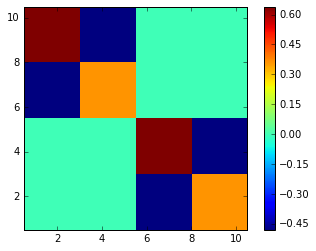

In [27]:
## Check what the projection looks like
plt.imshow((V*V_flat).real, interpolation='nearest', extent=(0.5,10.5,0.5,10.5))
plt.colorbar()

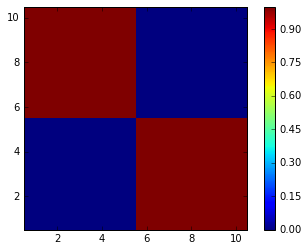

In [28]:
plt.imshow((V_flat*V).real, interpolation='nearest', extent=(0.5,10.5,0.5,10.5))
plt.colorbar()

In [29]:
## Construct factors for real roots.

F1 = lambda z: (numpy.matrix([[(z + significant_poles[1])/(z-significant_poles[0]), 0],
                            [0, (z + significant_poles[0])/(z-significant_poles[1])]])
                )

T_factorized_1 = lambda z: numpy.matrix(numpy.eye(D.shape[0])) - V*V_flat + V*la.inv(U)*F1(z)*(U)*V_flat

B_constant = T(1e12)*la.inv(T_factorized_1(1e12))

fact1 = lambda z: (B_constant*T_factorized_1(z)).T

### Ensure the generated factor is J-unitary and doubled-up

In [30]:
print all([[check_J_unitary(T_factorized_1,i+1j*j)
          for i in range(-5,5)] 
             for j in range(-5,5)])

print all([[check_doubled_up_func(T_factorized_1,i+1j*j)
          for i in range(-5,5)] 
             for j in range(-5,5)])

True
True


### Check the factor equals the original transfer function

In [31]:
def plot_T_and_fact(T, fact1, z):
    plt.title("Original transfer function, real part.")
    plt.imshow((T(z)).real, interpolation='nearest', extent=(0.5,10.5,0.5,10.5))
    plt.colorbar()
    plt.show()

    plt.title("New factor, real part.")
    plt.imshow((fact1(z)).real, interpolation='nearest', extent=(0.5,10.5,0.5,10.5))
    plt.colorbar()
    plt.show()

    plt.title("Original transfer function, imaginary part.")
    plt.imshow((T(z)).imag, interpolation='nearest', extent=(0.5,10.5,0.5,10.5))
    plt.colorbar()
    plt.show()

    plt.title("New factor, imaginary part.")
    plt.imshow((fact1(z)).imag, interpolation='nearest', extent=(0.5,10.5,0.5,10.5))
    plt.colorbar()
    plt.show()

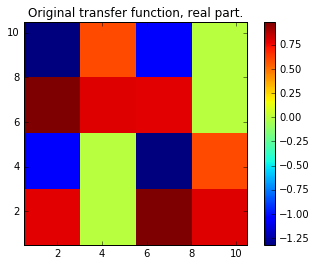

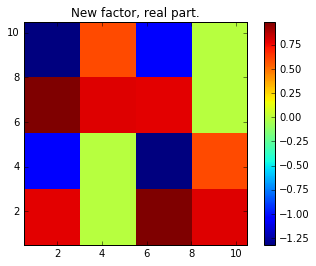

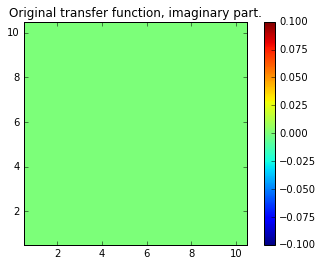

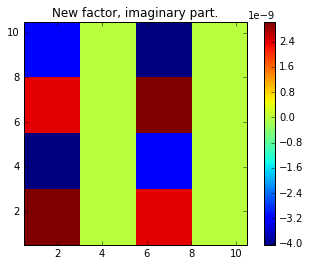

In [32]:
plot_T_and_fact(T, fact1, 0)

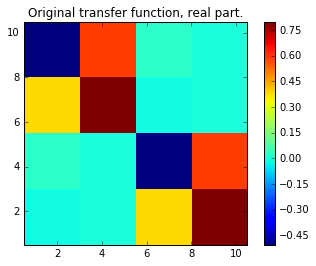

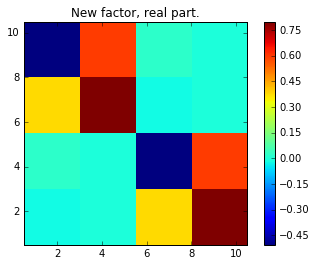

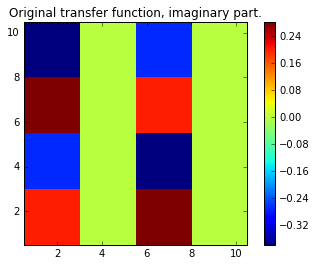

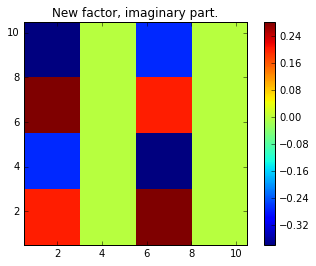

In [33]:
plot_T_and_fact(T, fact1, 1j+1.)

## Example 2. Next we close the feedback loop with a time delay and

### Feedback operation

In [34]:
T_old = sympy.lambdify(z, T_z_num)

In [35]:
P = numpy.matrix([[1,0,0,0],[0,0,1,0],[0,1,0,0],[0,0,0,1]])

In [36]:
P

matrix([[1, 0, 0, 0],
        [0, 0, 1, 0],
        [0, 1, 0, 0],
        [0, 0, 0, 1]])

In [37]:
T_o = P*T_z_num*P

In [38]:
T1 = sympy.lambdify(z, T_o[0:2,0:2])

In [39]:
T2 = sympy.lambdify(z, T_o[0:2,2:4])

In [40]:
T3 = sympy.lambdify(z, T_o[2:4,0:2])

In [41]:
T4 = sympy.lambdify(z, T_o[2:4, 2:4])

### Check some properties that should be true

In [42]:
Jv = numpy.matrix([[1,0],[0,-1]])

In [43]:
print la.norm(T1(0)*Jv*T1(0).H +T2(0)*Jv*T2(0).H - Jv) < 1e-5

True


In [44]:
print la.norm(T1(0)*Jv*T3(0).H +T2(0)*Jv*T4(0).H) < 1e-5

True


In [45]:
print la.norm(T3(0)*Jv*T3(0).H +T4(0)*Jv*T4(0).H - Jv) < 1e-5

True


In [46]:
I = numpy.matrix(numpy.eye(2))

### Feedback without time delay

In [47]:
T_tilde_0 = lambda z: T1(z) + T2(z)*la.inv(I - T4(z))* T3(z)

In [48]:
print all([[check_J_unitary(T_tilde_0,i+1j*j)
          for i in range(-5,5)] 
             for j in range(-5,5)])

print all([[check_doubled_up_func(T_tilde_0,i+1j*j)
          for i in range(-5,5)] 
             for j in range(-5,5)])

True
True


### Feedback with time delay

In [52]:
t = 2

In [53]:
E = lambda z: numpy.matrix(numpy.diag(numpy.exp(2*[-t*z])))

In [54]:
T_tilde = lambda z: T1(z) + T2(z) * la.inv( E(-z) - T4(z) ) * T3(z)

In [55]:
print all([[check_J_unitary(T_tilde,i+1j*j)
          for i in range(-5,5)] 
             for j in range(-5,5)])

print all([[check_doubled_up_func(T_tilde,i+1j*j)
          for i in range(-5,5)] 
             for j in range(-5,5)])

True
True


### Plot of input-output function

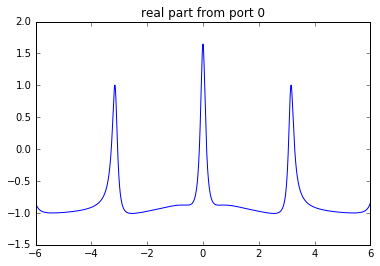

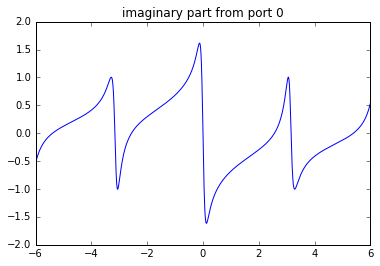

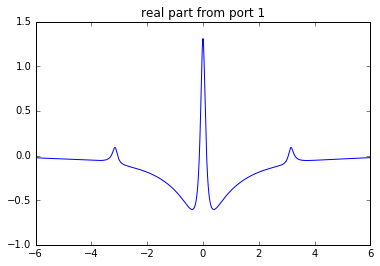

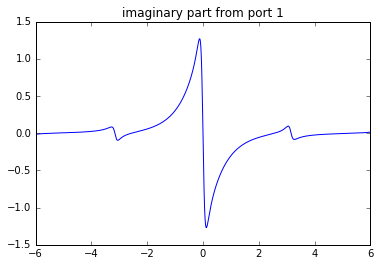

In [127]:
xr = numpy.linspace(-6,6,2000)
yr = numpy.array(map(T_tilde, xr*1j))

for i in range(yr.shape[1]):
    plt.title("real part from port %s" % str(i))
    plt.plot(xr, yr[:,i,0].real)
    plt.show()
    plt.title("imaginary part from port %s" % str(i))
    plt.plot(xr, yr[:,i,0].imag)
    plt.show()

In [57]:
## Analysis of squeezing spectrum.

# r_squeeze = 0.5*numpy.log((numpy.abs(yr[:,0,0])+numpy.abs(yr[:,1,0]))
#                           /(numpy.abs(yr[:,0,0])-numpy.abs(yr[:,1,0])))

# plt.plot(xr, r_squeeze)
# plt.show()


# # r_squeeze_trunc = 0.5*numpy.log((numpy.abs(zr[:,0,0])+numpy.abs(zr[:,1,0]))
# #                           /(numpy.abs(zr[:,0,0])-numpy.abs(zr[:,1,0])))


# # plt.plot(xr, r_squeeze_trunc)
# # plt.show()

# which_vals = yr

# N_ = which_vals[:,0,0]*which_vals[:,0,0].conj()
# M_ = which_vals[:,0,0]*numpy.flip(which_vals[:,0,1], axis=0)

# theta = 0#numpy.pi / 2

# A_ = numpy.exp(2j*theta)* M_ + numpy.exp(-2j*theta)* numpy.flip(M_, axis=0).conj()
# B_ = N_+numpy.flip(N_, axis=0)

## Squeezing power spectrum
# PP = 1 + A_ + B_
# plt.plot(xr, PP)

## Next, find the roots for $\tilde T(z)$.

In [61]:
# reload (Roots)

T_tilde_det = lambda z: 1./la.det(T_tilde(z))
# T_tilde_det_der = lambda z: der(T_tilde_det,z, eps=1e-15)


# poles_tilde = Roots.get_roots_rect(T_tilde_det, T_tilde_det_der, 0.,0.,5.,5., 
#                                   N=1000, outlier_coeff=10.,
#                                   max_steps=1,known_roots=[],verbose=False)

# # significant_poles_tilde = Roots.purge(poles_tilde, eps = 1e-5)
# # significant_poles_tilde
# poles_tilde

### The method above didn't work well, so we use grid + Muller search.

In [62]:
poles_tilde = []

for i in numpy.linspace(-10,10,100):
    for j in numpy.linspace(-10,10,100):
        x1,x2,x3 = i+j*1j-0.101, i+j*1j+0.101, i+j*1j+0.001
        p = Roots.Muller(x1,x2,x3,T_tilde_det)
        poles_tilde.append(p)

/Users/gil/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: overflow encountered in exp
  if __name__ == '__main__':
/Users/gil/anaconda/lib/python2.7/site-packages/numpy/linalg/linalg.py:1804: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


In [63]:
poles_tilde = numpy.asarray(purge(Roots.inside_boundary(poles_tilde, 0., 0., 10., 10.), 1e-1))

In [64]:
poles_tilde

array([-1.50999931 -9.79157347e-07j, -0.11168135 -9.42517756e+00j,
       -0.11168135 +9.42517756e+00j, -0.11144079 -3.14195389e+00j,
       -0.11144079 +3.14195389e+00j,  0.51000000 +5.11806044e-10j,
       -0.11204092 -2.29375751e-04j, -0.11115306 -6.28331596e+00j,
       -0.11178320 +6.28309085e+00j])

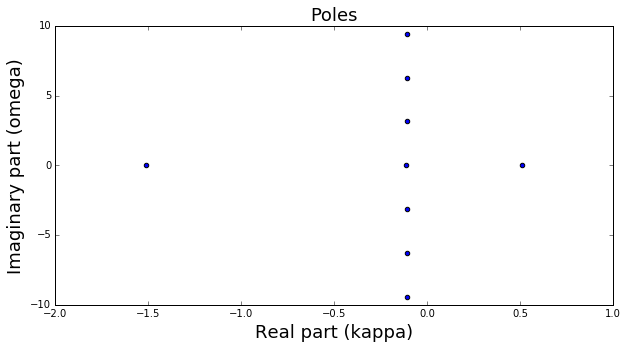

In [214]:
plt.figure(figsize=(10,5))
plt.scatter(poles_tilde.real,poles_tilde.imag, )
plt.title("Poles", fontsize=18)
plt.xlim(-2,1)
plt.ylim(-10,10)
plt.xlabel("Real part (kappa)", fontsize=18)
plt.ylabel("Imaginary part (omega)", fontsize=18)

### Organize the poles into different categories

In [129]:
real_cutoff = 1e-3

In [130]:
complex_poles = [p for p in poles_tilde if abs(p.imag) >= real_cutoff]

In [131]:
real_poles = [p.real for p in poles_tilde if abs(p.imag) < real_cutoff]

In [132]:
pos_complex_poles = [p for p in complex_poles if p.imag > real_cutoff]

In [133]:
neg_complex_poles =  [p for p in complex_poles if p.imag < -real_cutoff]

In [134]:
real_poles

### Factorize the (degenerate) complex poles

In [80]:
which_poles = pos_complex_poles

In [81]:
which_vecs = factorize_complex_poles(which_poles, T_tilde)

In [82]:
T_c = lambda z: complex_prod_deg(z, which_poles, which_vecs, 2)

In [136]:
### Check the resulting function is J-unitary and doubled-up.

In [135]:
print all([[check_J_unitary(T_c,i+1j*j)
          for i in range(-5,5)] 
             for j in range(-5,5)])

print all([[check_doubled_up_func(T_c,i+1j*j)
          for i in range(-5,5)] 
             for j in range(-5,5)])

True
True


In [137]:
### The example has both degenerate and non-degenerate real poles 
### They are seperated below.

In [146]:
deg_cutoff = 1e-3
deg_real_poles = []
non_deg_real_poles = []

for pole in real_poles:
    L = limit(lambda z: (z-pole)*T_tilde(z),pole, N=1000, eps=deg_cutoff*deg_cutoff)
    vals, vecs = la.eig(L)
    print la.norm(vals)
    if la.norm(vals) > deg_cutoff:
        non_deg_real_poles.append(pole)
    else:
        deg_real_poles.append(pole)

1.2792340041
0.617554756085
3.67766338621e-18


In [147]:
non_deg_real_poles

In [148]:
deg_real_poles

In [149]:
### Assume there are only two degenerate poles. Pair them together

In [150]:
p1, p2 = non_deg_real_poles
p3 = deg_real_poles[0]

In [100]:
### Factor out the non-degenerate poles.
T_factorized_1 = factorize_real_poles(p1, p2, T_tilde)

In [151]:
### Check J-unitary and doubled-up properties.
print all([[check_J_unitary(T_factorized_1,i+1j*j)
          for i in range(-5,5)] 
             for j in range(-5,5)])

print all([[check_doubled_up_func(T_factorized_1,i+1j*j)
          for i in range(-5,5)] 
             for j in range(-5,5)])

True
True


In [152]:
### Detach the factor T_factorized_1
T_tilde_2 = lambda z: T_tilde(z)*la.inv(T_factorized_1(z))

### Check to see poles are removed

In [157]:
## Values should be large near a pole
T_tilde(p1+1e-5)

matrix([[ 59849.98962415, -59851.9021455 ],
        [-59851.9021455 ,  59849.98962363]])

In [158]:
## Values should be O(1).
T_tilde_2(p1+1e-5)

matrix([[-1.23813295 +1.26103887e-12j, -0.04110124 +1.26100230e-12j],
        [-0.04110141 -1.26103114e-12j, -1.23813312 -1.26102510e-12j]])

In [159]:
## Values should be large near a pole
T_tilde(p2+1e-5)

matrix([[ 30879.48173785,  30879.79357648],
        [ 30879.79357648,  30879.48173801]])

In [160]:
## Values should be O(1).
T_tilde_2(p2+1e-5)

matrix([[ -6.17579461e-01 +7.29769275e-13j,
          -1.98916932e-05 -7.29760815e-13j],
        [ -2.00471768e-05 +7.29760599e-13j,
          -6.17579306e-01 -7.29791045e-13j]])

In [112]:
### factorize the degenerate real pole p3.
T_factorized_2 = factorize_deg_real_pole(p3, T_tilde_2)

In [113]:
### Detach the degenerate real pole p3.
T_tilde_3 = lambda z: T_tilde_2(z) * la.inv(T_factorized_2(z))

In [170]:
### Check J-unitary and doubled-up properties.
print all([[check_J_unitary(T_factorized_2,i+1j*j)
          for i in range(-5,5)] 
             for j in range(-5,5)])

print all([[check_doubled_up_func(T_factorized_2,i+1j*j)
          for i in range(-5,5)] 
             for j in range(-5,5)])

True
True


### Ensure the degenerate real root is removed

In [169]:
### Sholud be large
T_tilde_2(p3+1e-6)

matrix([[ -4.81643217e+02 -3.01067839e-14j,
          -2.19628804e-04 +3.83366332e-14j],
        [ -2.19628782e-04 -2.20795271e-14j,
          -4.81643217e+02 +3.27897736e-15j]])

In [168]:
### Should be O(1).
T_tilde_3(p3+1e-6)

matrix([[  2.14941707e-03 +1.34356980e-19j,
           1.03772500e-09 +2.41416534e-19j],
        [  9.22538869e-10 +5.11034225e-19j,
           2.14941728e-03 -1.46328205e-20j]])

### Generate and plot the factorized functions.

In [173]:
z0 = 0 ## Point at which we specify the new function should equal the original.
T_fact = lambda z: (T_tilde(z0)
                    * la.inv(T_factorized_2(z0))*T_factorized_2(z)
                    * la.inv(T_factorized_1(z0))*T_factorized_1(z)
                    * T_c(z))

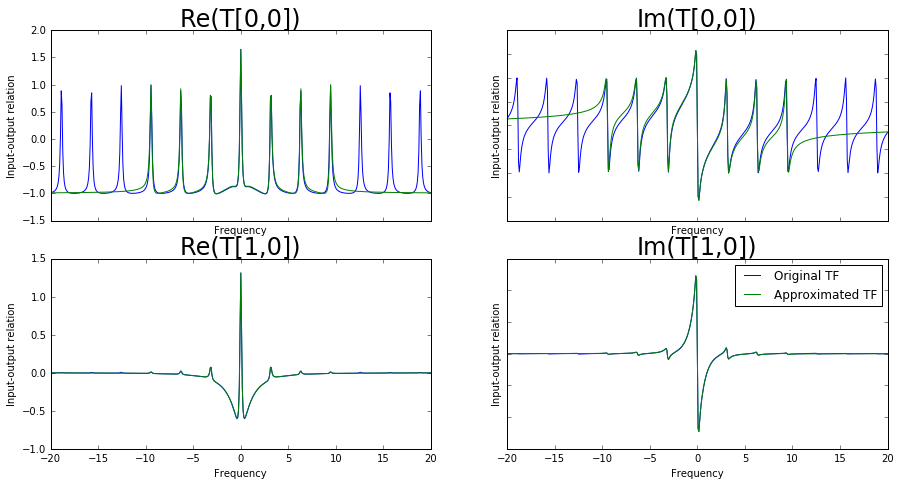

In [218]:

xr = numpy.linspace(-20,20,501)
xr_im = xr*1j
yr = numpy.array(map(T_tilde, xr_im))
zr = numpy.array(map(T_fact, xr_im))

f, axarr = plt.subplots(2, 2, figsize=(15,7.5))

l1, = axarr[0, 0].plot(xr, yr[:,0,0].real)
l2, = axarr[0, 0].plot(xr, zr[:,0,0].real)
axarr[0, 0].set_title('Re(T[0,0])',fontsize= 24)

axarr[0, 1].plot(xr, yr[:,0,0].imag)
axarr[0, 1].plot(xr, zr[:,0,0].imag)
axarr[0, 1].set_title('Im(T[0,0])' ,fontsize= 24)

axarr[1, 0].plot(xr, yr[:,1,0].real)
axarr[1, 0].plot(xr, zr[:,1,0].real)
axarr[1, 0].set_title('Re(T[1,0])',fontsize= 24 )

axarr[1, 1].plot(xr, yr[:,1,0].imag)
axarr[1, 1].plot(xr, zr[:,1,0].imag)
axarr[1, 1].set_title('Im(T[1,0])',fontsize= 24 )

plt.legend([l1, l2],["Original TF", "Approximated TF"])


for ax in axarr.flat:
    ax.set(xlabel='Frequency', ylabel='Input-output relation', )
# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axarr.flat:
    ax.label_outer()
    